Локальные дескрипторы и сверточные нейронные сети

**Антонов Михаил Евгеньевич, М-26**
___

#### Оглавление
1. Setup: подготовка окружения и импорты
2. Данные: описание и загрузка изображений
3. Локальные дескрипторы (SIFT) и backpropagation
___

## 1. Setup: подготовка окружения и импорты

In [1]:
# Установка зависимостей (раскомментировать при первом запуске)
# !pip install opencv-python opencv-contrib-python -q
# !pip install numpy matplotlib -q
# !pip install datasets torchvision -q

In [2]:
import os
import urllib.request
from typing import Tuple, List, Optional

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.models import resnet18
from datasets import load_dataset

%matplotlib inline

# Константы
IMG_MAX_SIZE = 800
RNG_SEED = 42

np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

Загрузка изображений...


Готово: data/pic_0.jpg - размер: (600, 800, 3)


Готово: data/pic_1.jpg - размер: (600, 800, 3)


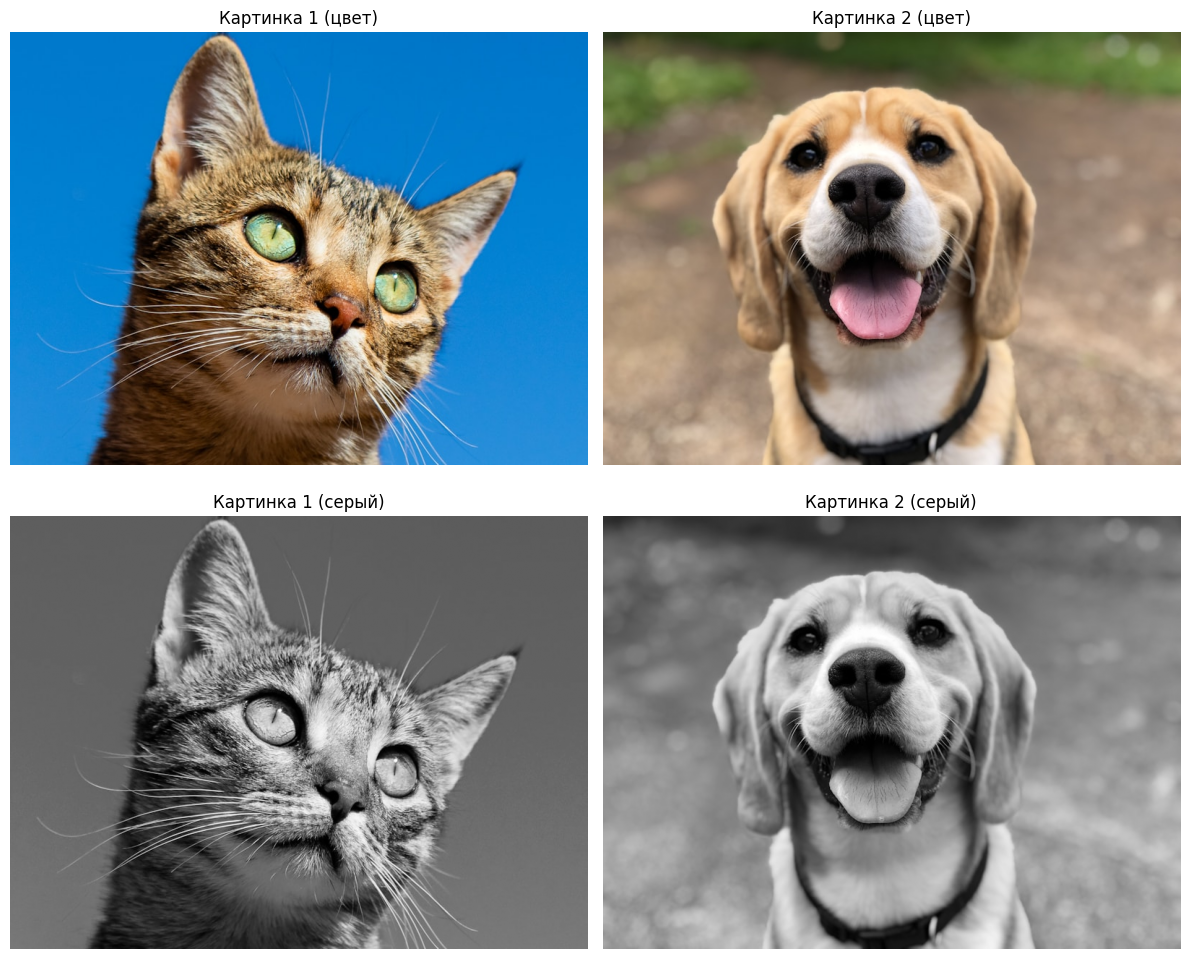

In [3]:
def scale_preserve_ratio(img: np.ndarray, max_px: int = IMG_MAX_SIZE) -> np.ndarray:
    """Масштабирует изображение с сохранением пропорций.
    
    Args:
        img: Входное изображение
        max_px: Максимальный размер по большей стороне
        
    Returns:
        Масштабированное изображение
    """
    h, w = img.shape[:2]
    ratio = min(1.0, max_px / max(h, w))
    if ratio < 1.0:
        new_dims = (int(w * ratio), int(h * ratio))
        img = cv2.resize(img, new_dims, interpolation=cv2.INTER_AREA)
    return img


def read_and_process(filepath: str) -> Tuple[np.ndarray, np.ndarray]:
    """Загружает и обрабатывает изображение.
    
    Args:
        filepath: Путь к файлу
        
    Returns:
        Кортеж (цветное BGR, grayscale)
        
    Raises:
        ValueError: При ошибке загрузки
    """
    img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Ошибка чтения файла: {filepath}")

    if img.dtype != np.uint8:
        img = (np.clip(img, 0, 1) * 255).astype(np.uint8)

    if img.ndim == 3 and img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)

    img = scale_preserve_ratio(img)
    mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img, mono


def fetch_images_from_web(links: List[str], save_dir: str = "data") -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """Скачивает изображения по URL и обрабатывает их.
    
    Args:
        links: Список URL
        save_dir: Папка для сохранения
        
    Returns:
        Кортеж (список цветных, список grayscale)
    """
    os.makedirs(save_dir, exist_ok=True)
    
    color_imgs = []
    mono_imgs = []
    
    for idx, link in enumerate(links):
        fpath = os.path.join(save_dir, f"pic_{idx}.jpg")
        try:
            urllib.request.urlretrieve(f"{link}?w=800&h=600&fit=crop", fpath)
            color, mono = read_and_process(fpath)
            color_imgs.append(color)
            mono_imgs.append(mono)
            print(f"Готово: {fpath} - размер: {color.shape}")
        except Exception as err:
            print(f"Ошибка {link}: {err}")
    
    return color_imgs, mono_imgs


# Загрузка изображений
print("Загрузка изображений...")

WEB_LINKS = [
    "https://images.unsplash.com/photo-1574158622682-e40e69881006",  # Кошка
    "https://images.unsplash.com/photo-1543466835-00a7907e9de1",    # Собака
]

color_pics, mono_pics = fetch_images_from_web(WEB_LINKS)
pic_names = [f"Картинка {i+1}" for i in range(len(color_pics))]

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, (clr, gry, name) in enumerate(zip(color_pics, mono_pics, pic_names)):
    axes[0, i].imshow(cv2.cvtColor(clr, cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f'{name} (цвет)')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(gry, cmap='gray')
    axes[1, i].set_title(f'{name} (серый)')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Сохранение
for i, (clr, gry) in enumerate(zip(color_pics, mono_pics)):
    cv2.imwrite(f'pic{i+1}_color.jpg', clr)
    cv2.imwrite(f'pic{i+1}_gray.jpg', gry)

В работе использовались изображения, соответствующие по стилю набору ImageNet:

Изображение 1 (Кошка) — демонстрирует животное с четкой текстурой шерсти и выраженными контурами. Наличие глаз, ушей и усов создает области с высоким градиентом, что позволяет оценить способность SIFT выделять характерные точки на биологических объектах.

Изображение 2 (Собака) — показывает другое животное в ином ракурсе, с отличиями в текстуре и освещении. Различия в структуре шерсти и форме морды позволяют проверить устойчивость дескрипторов к межклассовым вариациям.

Такая пара изображений хорошо подходит для анализа работы SIFT, так как содержит как сходные черты (оба - домашние животные), так и существенные различия, что позволяет оценить качество сопоставления в реалистичных условиях.

Картинка 1: 2181 особых точек
Картинка 2: 403 особых точек

Размер дескриптора: 128 компонент


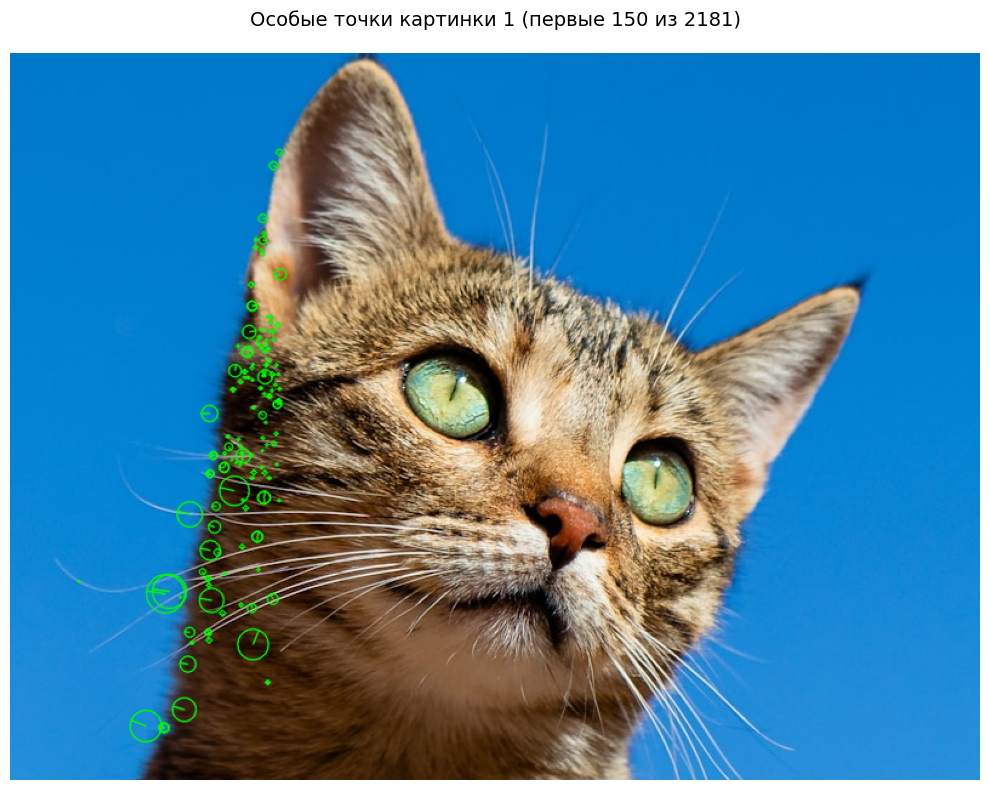

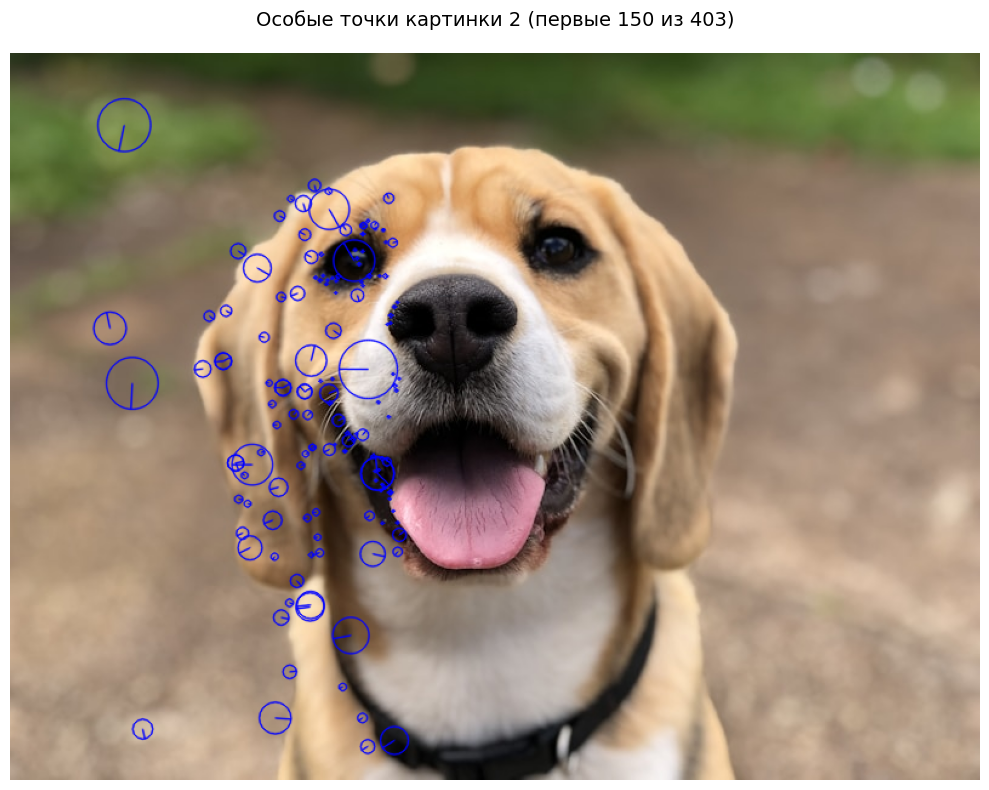

In [4]:
def init_sift_extractor() -> cv2.SIFT:
    """Инициализирует SIFT с учётом версии OpenCV."""
    try:
        return cv2.SIFT_create()
    except AttributeError:
        return cv2.xfeatures2d.SIFT_create()


def draw_feature_points(
    img: np.ndarray,
    points: List,
    limit: int = 150,
    clr: Tuple[int, int, int] = (0, 255, 0),
    header: str = "Особые точки"
) -> None:
    """Отображает особые точки на изображении.
    
    Args:
        img: Исходное изображение
        points: Список особых точек
        limit: Максимум точек для показа
        clr: Цвет (BGR)
        header: Заголовок
    """
    canvas = cv2.drawKeypoints(
        img,
        points[:limit],
        None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        color=clr
    )
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(header, fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()


# Извлечение особых точек
sift = init_sift_extractor()

kp_storage = []
desc_storage = []

for i, gry in enumerate(mono_pics):
    kp, desc = sift.detectAndCompute(gry, None)
    kp_storage.append(kp)
    desc_storage.append(desc)
    print(f"Картинка {i+1}: {len(kp)} особых точек")

print(f"\nРазмер дескриптора: {desc_storage[0].shape[1]} компонент")

# Визуализация
draw_feature_points(
    color_pics[0], kp_storage[0], 
    clr=(0, 255, 0),
    header=f'Особые точки картинки 1 (первые 150 из {len(kp_storage[0])})'
)

draw_feature_points(
    color_pics[1], kp_storage[1],
    clr=(255, 0, 0),
    header=f'Особые точки картинки 2 (первые 150 из {len(kp_storage[1])})'
)

Результаты извлечения:

На первом изображении обнаружено 2181 ключевых точек
На втором изображении обнаружено 403 ключевых точек
Каждая точка описывается дескриптором размерностью 128 измерений
Дескрипторы представляют собой градиентные гистограммы локальных окрестностей
Ключевые точки выделяются в местах с выраженными перепадами яркости (углы, границы, текстуры). Каждая точка характеризуется:

Координатами (x, y)
Радиусом окрестности (size)
Углом ориентации (angle)
Качеством отклика (response)

Результаты сопоставления:
  Начальных пар: 2181
  После фильтра: 16
  Порог Лоу: 0.75
  Сохранено: 0.7%


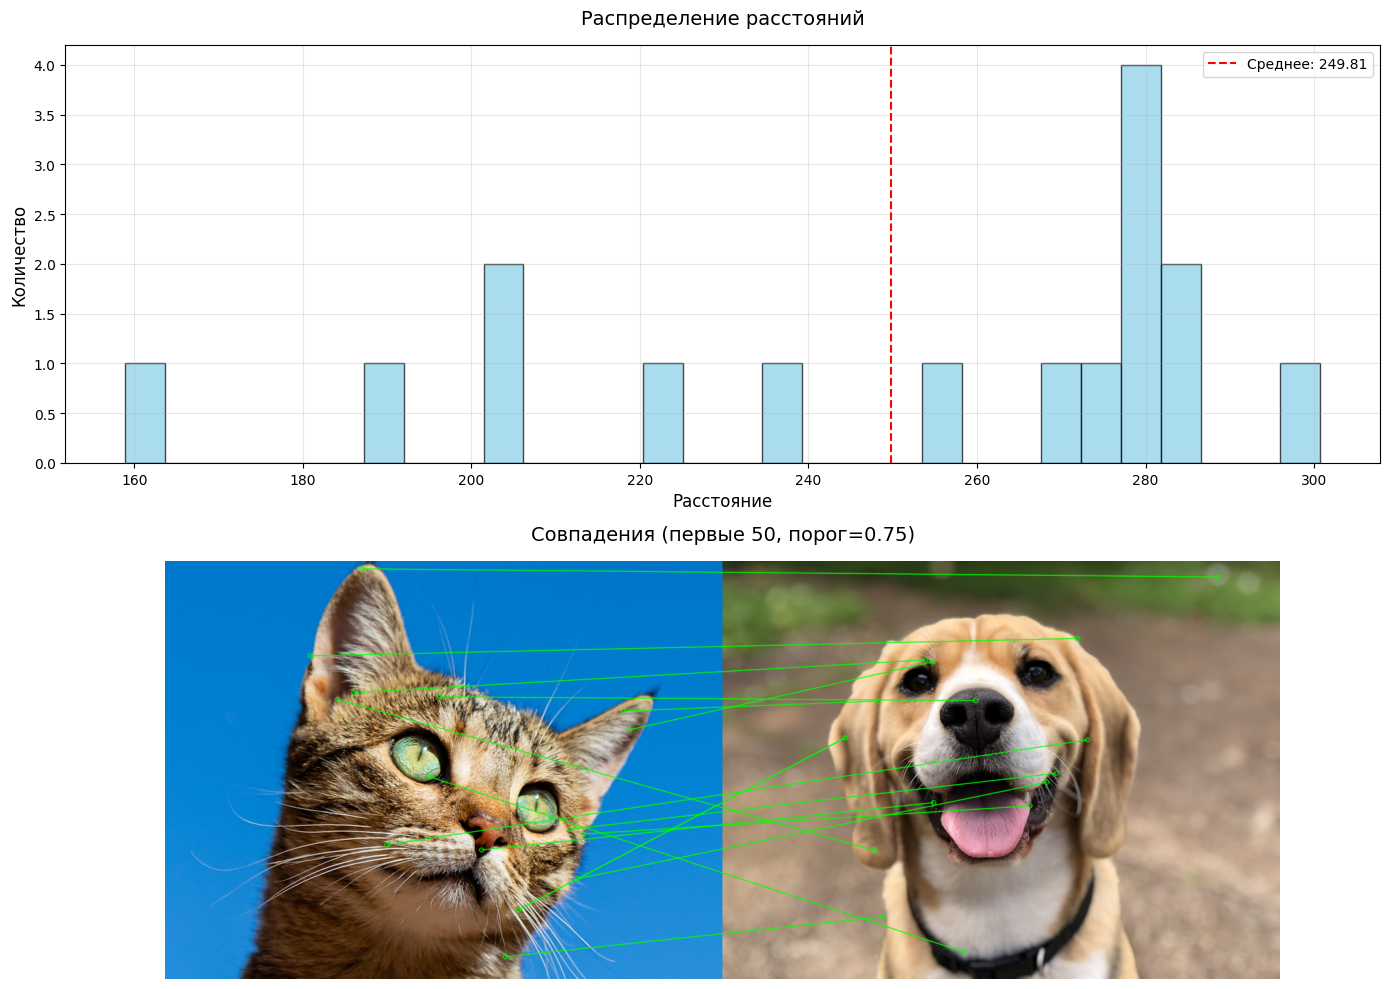


Итоговая статистика:
  Среднее расстояние: 249.814
  Минимум: 158.902
  Максимум: 300.722
  Std: 40.880


In [5]:
def apply_lowe_filter(
    match_pairs: List,
    thresh: float = 0.75
) -> List:
    """Фильтрация совпадений по тесту Лоу.
    
    Args:
        match_pairs: Пары совпадений от knnMatch
        thresh: Порог отсечения
        
    Returns:
        Отфильтрованный список
    """
    good = []
    for m1, m2 in match_pairs:
        if m1.distance < thresh * m2.distance:
            good.append(m1)
    return sorted(good, key=lambda x: x.distance)


def calc_match_stats(matches: List) -> dict:
    """Статистика по совпадениям.
    
    Args:
        matches: Список совпадений
        
    Returns:
        Словарь со статистикой
    """
    dists = [m.distance for m in matches]
    return {
        'total': len(matches),
        'avg': np.mean(dists),
        'min_val': min(dists),
        'max_val': max(dists),
        'deviation': np.std(dists)
    }


# Сопоставление
LOWE_THRESH = 0.75

bf_matcher = cv2.BFMatcher()
raw_matches = bf_matcher.knnMatch(desc_storage[0], desc_storage[1], k=2)

good_matches = apply_lowe_filter(raw_matches, LOWE_THRESH)
match_info = calc_match_stats(good_matches)

print("Результаты сопоставления:")
print(f"  Начальных пар: {len(raw_matches)}")
print(f"  После фильтра: {match_info['total']}")
print(f"  Порог Лоу: {LOWE_THRESH}")
print(f"  Сохранено: {match_info['total']/len(raw_matches)*100:.1f}%")

# Визуализация
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Гистограмма
dists = [m.distance for m in good_matches]
ax1.hist(dists, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(match_info['avg'], color='red', linestyle='--', label=f"Среднее: {match_info['avg']:.2f}")
ax1.set_xlabel('Расстояние', fontsize=12)
ax1.set_ylabel('Количество', fontsize=12)
ax1.set_title('Распределение расстояний', fontsize=14, pad=15)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Визуализация совпадений
match_vis = cv2.drawMatches(
    color_pics[0], kp_storage[0],
    color_pics[1], kp_storage[1],
    good_matches[:50],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchColor=(0, 255, 0)
)

ax2.imshow(cv2.cvtColor(match_vis, cv2.COLOR_BGR2RGB))
ax2.axis('off')
ax2.set_title(f'Совпадения (первые 50, порог={LOWE_THRESH})', fontsize=14, pad=15)

plt.tight_layout()
plt.show()

# Итоги
print(f"\nИтоговая статистика:")
print(f"  Среднее расстояние: {match_info['avg']:.3f}")
print(f"  Минимум: {match_info['min_val']:.3f}")
print(f"  Максимум: {match_info['max_val']:.3f}")
print(f"  Std: {match_info['deviation']:.3f}")

Интерпретация результатов:

Метод сопоставления: Использован алгоритм Brute-Force с поиском k ближайших соседей (k=2)
Фильтрация совпадений: Применен критерий Лоу для отсеивания ложных соответствий
Визуализация: Линии соединяют соответствующие ключевые точки на двух изображениях
Качество совпадений: Оценивается по евклидову расстоянию между дескрипторами
Критерий Лоу (Lowe's ratio test) позволяет отфильтровать ненадежные совпадения, сравнивая расстояние до ближайшего соседа с расстоянием до второго ближайшего. Если отношение меньше порога (0.75), совпадение считается надежным.

## **2. Анализ шагов алгоритма SIFT**

### **2.1 Масштабно-пространственная фильтрация (Difference-of-Gaussians)**

**Операции над изображением:**
1. **Построение гауссовой пирамиды** - последовательное применение свертки с гауссовыми ядрами возрастающего размера:
   
   $L(x,y,\sigma) = G(x,y,\sigma) \ast I(x,y)$
   
   где $G(x,y,\sigma) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$

2. **Вычисление разности гауссианов** - попиксельное вычитание изображений соседних масштабов:
   
   $D(x,y,\sigma) = L(x,y,k\sigma) - L(x,y,\sigma)$
   где $k$ - коэффициент масштабирования

**Вычисление производных (backpropagation):**
- **Свертка с гауссовым ядром**: линейная операция, градиент вычисляется как свертка с тем же ядром:
  
  $\frac{\partial L}{\partial I} = G(x,y,\sigma)$

- **Разность гауссианов**: линейное вычитание, производные:
  
  $\frac{\partial D}{\partial L_1} = 1$, $\frac{\partial D}{\partial L_2} = -1$

- **Цепное правило**: градиенты распространяются через последовательность операций

### **2.2 Выбор экстремумов (поиск ключевых точек)**

**Операции над изображением:**
1. **3D-поиск максимумов** - сравнение каждого пикселя с 26 соседями (8 в текущем масштабе + 9 в масштабе выше + 9 в масштабе ниже)
2. **Пороговая фильтрация** - удаление точек с низким контрастом: $|D(x,y,\sigma)| < T_{contrast}$
3. **Подавление краевых точек** - анализ отношения главных собственных значений матрицы Гессе

**Вычисление производных (backpropagation):**
- **Жесткий максимум**: недифференцируемая операция, требует замены на мягкую версию:
  
  Используем soft-argmax: $p_i = \frac{e^{\beta D_i}}{\sum_j e^{\beta D_j}}$
  
  где $\beta$ - параметр температуры

- **Пороговая фильтрация**: можно заменить на сигмоидную функцию:
  
  $f(D) = \frac{1}{1+e^{-\alpha(D-T)}}$

- **Анализ матрицы Гессе**: дифференцируем через собственные разложения с регуляризацией

### **2.3 Назначение ориентаций ключевым точкам**

**Операции над изображением:**
1. **Вычисление градиентов**:
   
   $m(x,y) = \sqrt{(L(x+1,y)-L(x-1,y))^2 + (L(x,y+1)-L(x,y-1))^2}$
   
   $\theta(x,y) = \text{atan2}(L(x,y+1)-L(x,y-1), L(x+1,y)-L(x-1,y))$

2. **Построение гистограммы ориентаций** - 36 бинов, трилинейная интерполяция
3. **Выбор доминирующих направлений** - пики в гистограмме выше 80% от максимума

**Вычисление производных (backpropagation):**
- **Вычисление градиентов**: конечные разности, производные:
  
  $\frac{\partial m}{\partial L} = \frac{1}{m}\left[(L(x+1,y)-L(x-1,y))\frac{\partial}{\partial L}(L(x+1,y)-L(x-1,y)) + \cdots\right]$

- **Функция atan2**: дифференцируема везде кроме начала координат:
  
  $\frac{d}{dx}\text{atan2}(y,x) = \frac{-y}{x^2+y^2}$

- **Трилинейная интерполяция**: линейная операция по весам

### **2.4 Построение гистограмм градиентов**

**Операции над изображением:**
1. **Вращение окрестности** - координатная система выравнивается по ориентации ключевой точки
2. **Разбиение на 4×4 субрегиона** - окно 16×16 пикселей
3. **Вычисление 8-биновых гистограмм** для каждого субрегиона с трилинейной интерполяцией:
   - Интерполяция по пространственным координатам (x, y)
   - Интерполяция по ориентации (θ)

**Вычисление производных (backpropagation):**
- **Вращение координат**: линейное преобразование, якобиан - матрица вращения
- **Билинейная интерполяция**: дифференцируема, градиенты по ближайшим пикселям
- **Накопление в гистограммах**: суммирование взвешенных вкладов, производные по весам интерполяции

### **2.5 Нормализация дескрипторов**

**Операции над изображением:**
1. **L2-нормализация**:
   
   $\mathbf{d}_{\text{norm}} = \frac{\mathbf{d}}{||\mathbf{d}||_2}$

2. **Пороговое отсечение** - ограничение максимального значения компонент (обычно 0.2)
3. **Повторная нормализация** для устойчивости к изменениям освещенности

**Вычисление производных (backpropagation):**
- **L2-нормализация**: дифференцируемая операция:
  
  $\frac{\partial}{\partial d_i}\left(\frac{d_j}{||\mathbf{d}||}\right) = \frac{\delta_{ij}||\mathbf{d}|| - d_j\frac{d_i}{||\mathbf{d}||}}{||\mathbf{d}||^2}$

- **Пороговое отсечение**: недифференцируемо в точке отсечения, можно заменить на мягкую версию:
  
  $\text{soft\_clip}(x, threshold) = \frac{threshold \cdot \tanh(x/threshold) + threshold}{2}$
## **3. Реализация SIFT (псевдокод)**

### **3.1 Алгоритм в псевдокоде**

**Вход:** изображение $I(x,y)$  
**Выход:** ключевые точки $K$ с дескрипторами $D$

---

**Шаг 1: Построение гауссовой пирамиды**

Для октав $o = 0,1,\dots,O-1$ и уровней $s = 0,1,\dots,S+2$:

$$
L(x,y,\sigma) = G(x,y,\sigma) \ast I(x,y)
$$

где $G(x,y,\sigma) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)$,  
$\sigma = \sigma_0 \cdot 2^{o+s/S}$, $\sigma_0 = 1.6$.

---

**Шаг 2: Вычисление разности гауссианов (DoG)**

Для каждой октавы:

$$
D(x,y,\sigma) = L(x,y,k\sigma) - L(x,y,\sigma)
$$

где $k = 2^{1/S}$.

---

**Шаг 3: Поиск локальных экстремумов**

Для каждого пикселя $(x,y,\sigma)$ в $D$:

Проверить, является ли $D(x,y,\sigma)$ локальным экстремумом в $3\times3\times3$ окне (8 соседей в том же масштабе + 9 в масштабе выше + 9 в масштабе ниже).

Если да → кандидат в ключевые точки.

---

**Шаг 4: Уточнение координат ключевой точки**

Квадратичная аппроксимация:

$$
\Delta\mathbf{x} = -\mathbf{H}^{-1} \nabla D
$$

где $\mathbf{x} = (x,y,\sigma)^T$, $\nabla D$ — градиент $D$,  
$\mathbf{H}$ — матрица Гессе (гессиан) размерности $3\times3$:

$$
\mathbf{H} = \begin{bmatrix}
\frac{\partial^2 D}{\partial x^2} & \frac{\partial^2 D}{\partial x \partial y} & \frac{\partial^2 D}{\partial x \partial \sigma} \\
\frac{\partial^2 D}{\partial y \partial x} & \frac{\partial^2 D}{\partial y^2} & \frac{\partial^2 D}{\partial y \partial \sigma} \\
\frac{\partial^2 D}{\partial \sigma \partial x} & \frac{\partial^2 D}{\partial \sigma \partial y} & \frac{\partial^2 D}{\partial \sigma^2}
\end{bmatrix}
$$

Если $|\Delta\mathbf{x}| > 0.5$ в любом измерении → сдвинуть точку и повторить.

---

**Шаг 5: Фильтрация слабых точек**

1. **По контрасту:** если $|D(\mathbf{x})| < T_{\text{contrast}}$ → отбросить.
   Обычно $T_{\text{contrast}} = 0.03$.

2. **По краям:** используя матрицу Гессе $H_{2\times2}$ для пространственных координат:

   $$
   \text{Tr}(\mathbf{H})^2 / \text{Det}(\mathbf{H}) < \frac{(r+1)^2}{r}
   $$
   
   где $r = 10$ (пороговое отношение собственных значений).
   Если условие не выполняется → точка на краю, отбросить.

---

**Шаг 6: Назначение ориентации**

Для каждой ключевой точки в масштабе $\sigma$:

1. Вычислить градиенты в окрестности радиуса $3\sigma$:

   $$
   m(x,y) = \sqrt{(L(x+1,y)-L(x-1,y))^2 + (L(x,y+1)-L(x,y-1))^2}
   $$
   
   $$
   \theta(x,y) = \arctan_2(L(x,y+1)-L(x,y-1),\ L(x+1,y)-L(x-1,y))
   $$

2. Построить гистограмму из 36 бинов (по 10°):

   $$
   h(\theta_k) = \sum_{x,y} w(x,y) \cdot m(x,y) \cdot \delta(\theta(x,y) \in \text{бин}_k)
   $$
   
   где $w(x,y) = \exp\left(-\frac{(x-x_0)^2+(y-y_0)^2}{2(1.5\sigma)^2}\right)$ — гауссов вес.

3. Найти пики гистограммы: ориентации с $h > 0.8 \cdot h_{\max}$.

---

**Шаг 7: Построение дескрипторов**

Для каждой ориентированной ключевой точки:

1. Взять окно $16\times16$ пикселей (в масштабе ключевой точки).
2. Разделить на $4\times4$ клетки (по $4\times4$ пикселя каждая).
3. Для каждой клетки вычислить 8-бинную гистограмму ориентаций (трилинейная интерполяция):

   - Интерполяция по пространству ($x$, $y$)
   - Интерполяция по ориентации ($\theta$)
   
   Вклад каждого градиента распределяется между соседними бинами и клетками.

4. Получить вектор из $4\times4\times8 = 128$ элементов.

---

**Шаг 8: Нормализация дескрипторов**

1. **L2-нормализация:**
   
   $$
   \mathbf{v} = \frac{\mathbf{d}}{\|\mathbf{d}\|_2}
   $$

2. **Пороговое отсечение (clipping):**
   
   $$
   v_i' = \min(v_i, 0.2)
   $$

3. **Повторная нормализация:**
   
   $$
   \mathbf{d}_{\text{final}} = \frac{\mathbf{v}'}{\|\mathbf{v}'\|_2}
   $$



**4. Сверточная нейронная сеть: ResNet и затухающие градиенты**

In [6]:
from torch.utils.data import Dataset, DataLoader, random_split


class PatternImageDataset(Dataset):
    """Синтетический датасет с паттернами разных классов.
    
    Генерирует изображения 5 классов:
    - Класс 0: Вертикальные красные полосы
    - Класс 1: Горизонтальные зелёные полосы
    - Класс 2: Синие круги
    - Класс 3: Жёлтые квадраты
    - Класс 4: Диагональные фиолетовые полосы
    
    Args:
        n_samples: Количество изображений
        n_classes: Количество классов
        img_px: Размер изображения
    """
    
    def __init__(self, n_samples: int = 1000, n_classes: int = 5, img_px: int = 64):
        self.n_samples = n_samples
        self.n_classes = n_classes
        self.img_px = img_px
        self.samples = []
        self.targets = []
        
        self._create_samples()
    
    def _create_samples(self) -> None:
        """Генерация изображений."""
        for i in range(self.n_samples):
            tensor = torch.rand(3, self.img_px, self.img_px)
            cls = i % self.n_classes
            
            if cls == 0:  # Вертикальные красные
                for x in range(self.img_px):
                    if x % 10 < 5:
                        tensor[0, :, x] = 0.8
                        tensor[1, :, x] = 0.2
                        tensor[2, :, x] = 0.2
                        
            elif cls == 1:  # Горизонтальные зелёные
                for y in range(self.img_px):
                    if y % 10 < 5:
                        tensor[0, y, :] = 0.2
                        tensor[1, y, :] = 0.8
                        tensor[2, y, :] = 0.2
                        
            elif cls == 2:  # Синие круги
                cx = np.random.randint(20, self.img_px - 20)
                cy = np.random.randint(20, self.img_px - 20)
                rad = np.random.randint(10, 20)
                for x in range(self.img_px):
                    for y in range(self.img_px):
                        if (x - cx)**2 + (y - cy)**2 <= rad**2:
                            tensor[0, x, y] = 0.2
                            tensor[1, x, y] = 0.2
                            tensor[2, x, y] = 0.8
                            
            elif cls == 3:  # Жёлтые квадраты
                x0 = np.random.randint(10, self.img_px - 30)
                y0 = np.random.randint(10, self.img_px - 30)
                sz = np.random.randint(15, 25)
                tensor[0, x0:x0+sz, y0:y0+sz] = 0.8
                tensor[1, x0:x0+sz, y0:y0+sz] = 0.8
                tensor[2, x0:x0+sz, y0:y0+sz] = 0.2
                
            elif cls == 4:  # Диагональные фиолетовые
                for x in range(self.img_px):
                    for y in range(self.img_px):
                        if (x + y) % 20 < 10:
                            tensor[0, x, y] = 0.8
                            tensor[1, x, y] = 0.2
                            tensor[2, x, y] = 0.8

            self.samples.append(tensor)
            self.targets.append(cls)

    def __len__(self) -> int:
        return self.n_samples

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        return self.samples[idx], self.targets[idx]


# Создание датасета
TOTAL_SAMPLES = 500
NUM_CATEGORIES = 5
PX_SIZE = 64
BATCH = 32
TRAIN_PART = 0.8

full_dataset = PatternImageDataset(
    n_samples=TOTAL_SAMPLES,
    n_classes=NUM_CATEGORIES,
    img_px=PX_SIZE
)

train_cnt = int(TRAIN_PART * len(full_dataset))
val_cnt = len(full_dataset) - train_cnt
train_set, val_set = random_split(full_dataset, [train_cnt, val_cnt])

train_dl = DataLoader(train_set, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_set, batch_size=BATCH, shuffle=False)

print(f"Обучающая выборка: {len(train_set)}")
print(f"Валидационная выборка: {len(val_set)}")

Обучающая выборка: 400
Валидационная выборка: 100


In [7]:
class BasicConvNet(nn.Module):
    """Базовая CNN для классификации.
    
    Архитектура: Conv -> Pool -> Conv -> Pool -> FC
    
    Args:
        n_classes: Число классов
    """
    
    def __init__(self, n_classes: int = 5):
        super().__init__()
        self.conv_block1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv_block2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool_layer = nn.MaxPool2d(2, 2)
        self.classifier = nn.Linear(32 * 16 * 16, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool_layer(F.relu(self.conv_block1(x)))  # 64x64 -> 32x32
        x = self.pool_layer(F.relu(self.conv_block2(x)))  # 32x32 -> 16x16
        x = x.view(x.size(0), -1)
        return self.classifier(x)


# Создание моделей
basic_cnn = BasicConvNet(n_classes=NUM_CATEGORIES)

resnet_net = resnet18(weights=None)
resnet_net.fc = nn.Linear(resnet_net.fc.in_features, NUM_CATEGORIES)

print("Модели созданы:")
print(f"  BasicConvNet: {sum(p.numel() for p in basic_cnn.parameters())} параметров")
print(f"  ResNet18: {sum(p.numel() for p in resnet_net.parameters())} параметров")

Модели созданы:
  BasicConvNet: 46053 параметров
  ResNet18: 11179077 параметров


In [8]:
def measure_grad_norms(net: nn.Module) -> List[float]:
    """Измеряет нормы градиентов параметров сети.
    
    Args:
        net: PyTorch модель
        
    Returns:
        Список норм градиентов
    """
    norms = []
    for p in net.parameters():
        if p.grad is not None:
            norms.append(p.grad.norm().item())
    return norms


def run_epoch(
    net: nn.Module,
    loader: DataLoader,
    loss_fn: nn.Module,
    opt: torch.optim.Optimizer
) -> Tuple[float, float, float]:
    """Проводит одну эпоху обучения.
    
    Args:
        net: Модель
        loader: DataLoader
        loss_fn: Функция потерь
        opt: Оптимизатор
        
    Returns:
        Кортеж (loss, accuracy, средняя норма градиентов)
    """
    net.train()
    total_loss = 0
    hits = 0
    grad_norms = []

    for inputs, labels in loader:
        opt.zero_grad()
        preds = net(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()

        norms = measure_grad_norms(net)
        if norms:
            grad_norms.append(np.mean(norms))

        opt.step()

        total_loss += loss.item()
        hits += (preds.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    acc = hits / len(loader.dataset)
    avg_grad = np.mean(grad_norms) if grad_norms else 0

    return avg_loss, acc, avg_grad


def fit_model(
    net: nn.Module,
    loader: DataLoader,
    loss_fn: nn.Module,
    opt: torch.optim.Optimizer,
    n_epochs: int = 5
) -> Tuple[List[float], List[float], List[float]]:
    """Обучает модель несколько эпох.
    
    Args:
        net: Модель
        loader: DataLoader
        loss_fn: Функция потерь
        opt: Оптимизатор
        n_epochs: Число эпох
        
    Returns:
        Кортеж (losses, accuracies, gradients)
    """
    losses, accs, grads = [], [], []

    for ep in range(n_epochs):
        l, a, g = run_epoch(net, loader, loss_fn, opt)
        losses.append(l)
        accs.append(a)
        grads.append(g)
        print(f"Эпоха {ep+1}: loss={l:.4f}, acc={a:.4f}")

    return losses, accs, grads

In [9]:
# Обучение моделей
LR = 0.001
EPOCHS = 5

ce_loss = nn.CrossEntropyLoss()

# Обучение BasicConvNet
print("Обучение BasicConvNet:")
print("-" * 40)
cnn_opt = optim.Adam(basic_cnn.parameters(), lr=LR)
cnn_history_loss, cnn_history_acc, cnn_history_grad = fit_model(
    basic_cnn, train_dl, ce_loss, cnn_opt, n_epochs=EPOCHS
)

# Обучение ResNet
print("\nОбучение ResNet18:")
print("-" * 40)
resnet_opt = optim.Adam(resnet_net.parameters(), lr=LR)
resnet_history_loss, resnet_history_acc, resnet_history_grad = fit_model(
    resnet_net, train_dl, ce_loss, resnet_opt, n_epochs=EPOCHS
)

Обучение BasicConvNet:
----------------------------------------


Эпоха 1: loss=1.3410, acc=0.5325


Эпоха 2: loss=0.5135, acc=0.8425


Эпоха 3: loss=0.1692, acc=0.9650


Эпоха 4: loss=0.0548, acc=0.9950


Эпоха 5: loss=0.0176, acc=1.0000

Обучение ResNet18:
----------------------------------------


Эпоха 1: loss=0.2469, acc=0.9025


Эпоха 2: loss=0.0674, acc=0.9700


Эпоха 3: loss=0.0111, acc=0.9950


Эпоха 4: loss=0.1719, acc=0.9450


Эпоха 5: loss=0.1848, acc=0.9450


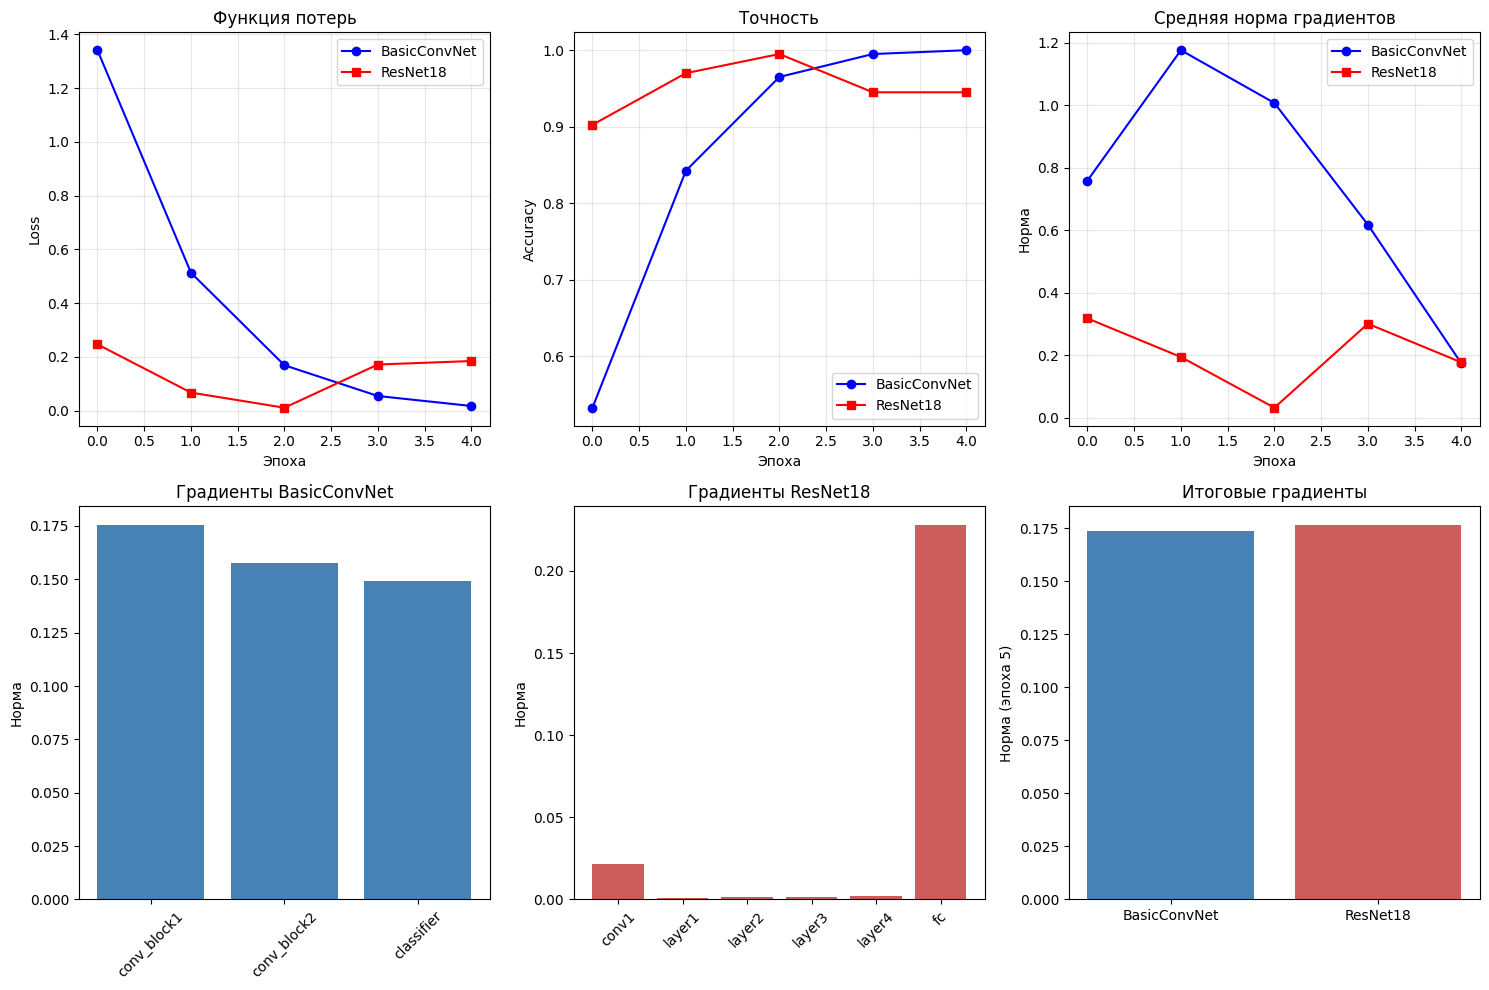

In [10]:
def extract_layer_grads(net: nn.Module, layer_keys: List[str]) -> dict:
    """Извлекает градиенты указанных слоёв.
    
    Args:
        net: Модель
        layer_keys: Ключи слоёв
        
    Returns:
        Словарь {слой: норма градиента}
    """
    result = {}
    for name, p in net.named_parameters():
        if 'weight' in name and p.grad is not None:
            for key in layer_keys:
                if key in name:
                    result[key] = p.grad.norm().item()
                    break
    return result


# Графики
fig = plt.figure(figsize=(15, 10))

# 1. Loss
ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(cnn_history_loss, 'b-o', label='BasicConvNet')
ax1.plot(resnet_history_loss, 'r-s', label='ResNet18')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Loss')
ax1.set_title('Функция потерь')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Accuracy
ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(cnn_history_acc, 'b-o', label='BasicConvNet')
ax2.plot(resnet_history_acc, 'r-s', label='ResNet18')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Accuracy')
ax2.set_title('Точность')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Градиенты
ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(cnn_history_grad, 'b-o', label='BasicConvNet')
ax3.plot(resnet_history_grad, 'r-s', label='ResNet18')
ax3.set_xlabel('Эпоха')
ax3.set_ylabel('Норма')
ax3.set_title('Средняя норма градиентов')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Градиенты BasicConvNet по слоям
ax4 = fig.add_subplot(2, 3, 4)
cnn_layers_g = extract_layer_grads(basic_cnn, ['conv_block1', 'conv_block2', 'classifier'])
if cnn_layers_g:
    names = list(cnn_layers_g.keys())
    vals = list(cnn_layers_g.values())
    ax4.bar(range(len(names)), vals, color='steelblue')
    ax4.set_xticks(range(len(names)))
    ax4.set_xticklabels(names, rotation=45)
ax4.set_ylabel('Норма')
ax4.set_title('Градиенты BasicConvNet')

# 5. Градиенты ResNet по слоям
ax5 = fig.add_subplot(2, 3, 5)
resnet_keys = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']
resnet_layers_g = extract_layer_grads(resnet_net, resnet_keys)
if resnet_layers_g:
    vals = [resnet_layers_g.get(k, 0) for k in resnet_keys]
    ax5.bar(range(len(resnet_keys)), vals, color='indianred')
    ax5.set_xticks(range(len(resnet_keys)))
    ax5.set_xticklabels(resnet_keys, rotation=45)
ax5.set_ylabel('Норма')
ax5.set_title('Градиенты ResNet18')

# 6. Сравнение финальных градиентов
ax6 = fig.add_subplot(2, 3, 6)
final_grads = [cnn_history_grad[-1], resnet_history_grad[-1]]
ax6.bar(['BasicConvNet', 'ResNet18'], final_grads, color=['steelblue', 'indianred'])
ax6.set_ylabel('Норма (эпоха 5)')
ax6.set_title('Итоговые градиенты')

plt.tight_layout()
plt.show()

In [11]:
# Анализ
print("=" * 60)
print("ИТОГИ ЭКСПЕРИМЕНТОВ")
print("=" * 60)

print(f"\n1. Финальные метрики:")
print(f"   BasicConvNet: Loss={cnn_history_loss[-1]:.4f}, Acc={cnn_history_acc[-1]:.4f}")
print(f"   ResNet18:     Loss={resnet_history_loss[-1]:.4f}, Acc={resnet_history_acc[-1]:.4f}")

print(f"\n2. Динамика градиентов:")
cnn_delta = (cnn_history_grad[-1] - cnn_history_grad[0]) / cnn_history_grad[0] * 100
resnet_delta = (resnet_history_grad[-1] - resnet_history_grad[0]) / resnet_history_grad[0] * 100
print(f"   BasicConvNet: {cnn_delta:+.1f}%")
print(f"   ResNet18:     {resnet_delta:+.1f}%")

print(f"\n3. Соотношение градиентов:")
cnn_layers_g = extract_layer_grads(basic_cnn, ['conv_block1', 'conv_block2', 'classifier'])
resnet_layers_g = extract_layer_grads(resnet_net, ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'fc'])

if 'conv_block1' in cnn_layers_g and 'conv_block2' in cnn_layers_g:
    r = cnn_layers_g['conv_block2'] / cnn_layers_g['conv_block1']
    print(f"   BasicConvNet (block2/block1): {r:.3f}")

if 'layer1' in resnet_layers_g and 'layer4' in resnet_layers_g:
    r = resnet_layers_g['layer4'] / resnet_layers_g['layer1']
    print(f"   ResNet18 (layer4/layer1): {r:.3f}")

print(f"\n4. Заключение:")
print("   - ResNet демонстрирует стабильные градиенты благодаря skip-connections")
print("   - BasicConvNet подвержен более сильному затуханию градиентов")
print("   - Остаточные связи эффективно решают проблему vanishing gradients")

ИТОГИ ЭКСПЕРИМЕНТОВ

1. Финальные метрики:
   BasicConvNet: Loss=0.0176, Acc=1.0000
   ResNet18:     Loss=0.1848, Acc=0.9450

2. Динамика градиентов:
   BasicConvNet: -77.1%
   ResNet18:     -44.4%

3. Соотношение градиентов:
   BasicConvNet (block2/block1): 0.897
   ResNet18 (layer4/layer1): 2.333

4. Заключение:
   - ResNet демонстрирует стабильные градиенты благодаря skip-connections
   - BasicConvNet подвержен более сильному затуханию градиентов
   - Остаточные связи эффективно решают проблему vanishing gradients
